<a href="https://colab.research.google.com/github/CosmoStat/jax-lensing/blob/master/notebooks/ScoreKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/CosmoStat/jax-lensing.git
import os
os.chdir('jax-lensing')
!pip install .
!pip install git+https://github.com/deepmind/dm-haiku

Cloning into 'jax-lensing'...
remote: Enumerating objects: 152, done.
remote: Total 152 (delta 0), reused 0 (delta 0), pack-reused 152
Receiving objects: 100% (152/152), 181.70 MiB | 24.59 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Checking out files: 100% (40/40), done.
Processing /content/jax-lensing
  Created wheel for jax-lensing: filename=jax_lensing-0.1-cp36-none-any.whl size=4685 sha256=f91aae9a5740456b9a984aaa978b2dde0a701ae8dc1992750e05aecacd6062cc
  Stored in directory: /root/.cache/pip/wheels/31/5b/86/e29205d100779fcb45270ad33e29cb25072a1301b8b8f9b64e
Successfully built jax-lensing
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-elcpfqic
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-elcpfqic
  Created wheel for dm-haiku: filename=dm_haiku-0.0.2-cp36-none-any.whl size=293301 sha256=a9dddca92d9068bda360d6680257ea7ac3f2d5f4c9b9dd71c9223ce5315ddfe0
  Stored in directory: /tmp/pip-ephem-wheel-cache-9mgx2jfk/whe

In [2]:
%pylab inline
import tensorflow as tf
import tensorflow_datasets as tfds

from jax_lensing.datasets.massivenu import MassiveNu
from jax_lensing.models.convdae import SmallUResNet, UResNet

import numpy as onp
import jax
import jax.numpy as jnp
from jax.experimental import optix

import haiku as hk

Populating the interactive namespace from numpy and matplotlib


In [3]:
import types
from typing import Mapping, Optional, Sequence, Union

class MediumUResNet(UResNet):
  """ResNet18."""

  def __init__(self,
               bn_config: Optional[Mapping[str, float]] = None,
               name: Optional[str] = None):
    """Constructs a ResNet model.
    Args:
      bn_config: A dictionary of two elements, ``decay_rate`` and ``eps`` to be
        passed on to the :class:`~haiku.BatchNorm` layers.
      resnet_v2: Whether to use the v1 or v2 ResNet implementation. Defaults
        to ``False``.
      name: Name of the module.
    """
    super().__init__(blocks_per_group=(2, 2, 2, 2),
                     bn_config=bn_config,
                     bottleneck=False,
                     channels_per_group=(32, 64, 128, 128),
                     use_projection=(True, True, True, True),
                     name=name)
    
def forward(x, s, is_training=False):
    denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

In [4]:
# Loading params from cloud
import pickle
with tf.io.gfile.GFile('gs://ouliers/score/lensing-conv-dae-noreg-2.pckl', 'rb') as file:
    params, state = pickle.load(file)
    
from functools import partial
rng_seq = hk.PRNGSequence(42)
score = partial(model.apply, params, state, next(rng_seq))

In [5]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

def score_fn(x, sigma):
    return score(x.reshape((-1,320,320,1)), sigma.reshape((-1,1,1,1)), is_training=False)[0].reshape((-1, 320*320))

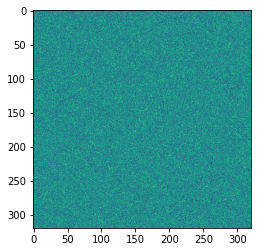

In [6]:
init_image=0.2*randn(1,320,320).reshape((-1, 320*320,)).astype('float32')
imshow(init_image[0].reshape((320,320)))

In [7]:
def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=0.0002,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=score_fn,
            inverse_temperatures=0.2*np.ones([1]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.9999,
            min_steps_per_temp=10,
            num_delta_logp_steps=4)

num_results = int(1e1)
num_burnin_steps = int(1)

samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_image,
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures),
        seed=jax.random.PRNGKey(0))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[Traced<ShapedArray(float32[1,102400]):JaxprTrace(level=1/0)>]


In [8]:
from jax_lensing.inversion import ks93inv

In [9]:
i = 0
data_x = onp.load('./data/massivenu/'+str(i)+'/x.npy')
data_y = onp.load('./data/massivenu/'+str(i)+'/y.npy')
data_s = onp.load('./data/massivenu/'+str(i)+'/s.npy')
data_u = onp.load('./data/massivenu/'+str(i)+'/u.npy')

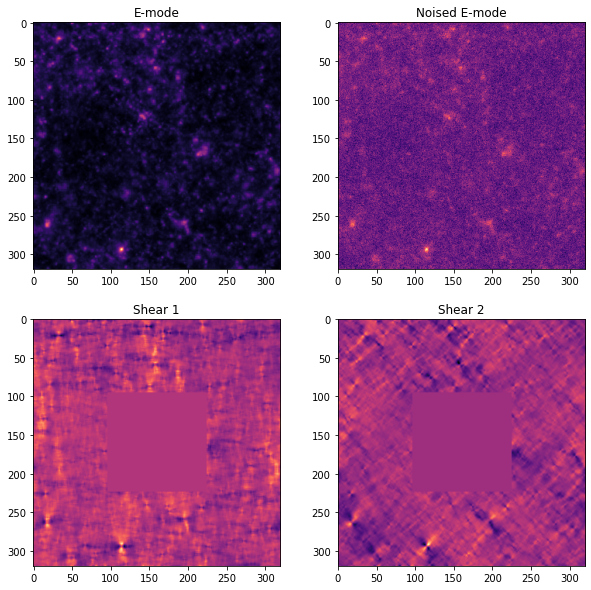

In [10]:
figure(figsize=(10,10))
#for batch in dataset.take(1):  # Only take a single example
m = onp.ones_like(data_x[0])
m[160-64:160+64, 160-64:160+64] = 0.
mask = jnp.array(m)

subplot(221)
e_mode = data_y[0].reshape((320, 320))
b_mode = jnp.zeros(e_mode.shape)
imshow(e_mode,cmap='magma')
plt.title('E-mode')

subplot(222)
imshow(data_x[0].reshape((320, 320)),cmap='magma')
plt.title('Noised E-mode')
#plt.colorbar()

ke = e_mode
kb = b_mode
g1, g2 = ks93inv(ke, kb)

masked_g1, masked_g2 = mask.reshape((320, 320))*g1, mask.reshape((320, 320))*g2

plt.subplot(223)
imshow(masked_g1 ,cmap='magma')
plt.title('Shear 1')

plt.subplot(224)    
imshow(masked_g2,cmap='magma')
plt.title('Shear 2')

true_shear = jnp.stack([masked_g1, masked_g2], axis=0).flatten()

In [11]:
def likelihood_fn(x, sigma):
    ke = x.reshape((320, 320))
    kb = jnp.zeros(ke.shape)
    
    gamma1, gamma2 = ks93inv(ke, kb)
    masked_gamma1, masked_gamma2 = mask.reshape((320, 320))*gamma1, gamma2*mask.reshape((320, 320))
    shear = jnp.stack([masked_gamma1, masked_gamma2], axis=0).flatten()
    return jnp.sum( ((shear-true_shear)/(1e-2 + sigma))**2 )/2.

score_likelihood = jax.vmap(jax.grad(likelihood_fn))

In [12]:
def score_fn(x, sigma):
  return ( score(x.reshape((-1,320,320,1)), sigma.reshape((-1,1,1,1)), is_training=False)[0] + 
            - score_likelihood(x.reshape((-1,320,320,1)), sigma.reshape((-1,1,1,1)))
          ).reshape((-1, 320*320))

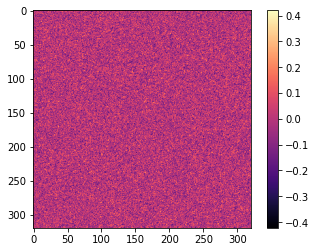

In [13]:
init_image=(0.1*randn(1,320,320)).reshape((-1, 320*320,)).astype('float32')
imshow(init_image.reshape((320,320)), cmap='magma')
colorbar()

In [14]:
%%time

s0 = 0.1
def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=0.002*(np.max(sigma)/s0)**0.5,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=score_fn,
            inverse_temperatures=s0*np.ones([1]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.98,
            min_steps_per_temp=20,
            num_delta_logp_steps=4)

num_results = int(2e3)
num_burnin_steps = int(0)

samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_image,
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=1,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[Traced<ShapedArray(float32[1,102400]):JaxprTrace(level=1/0)>]
CPU times: user 4min 31s, sys: 2min 18s, total: 6min 50s
Wall time: 6min 52s


Text(0.5, 1.0, ' accept tempering')

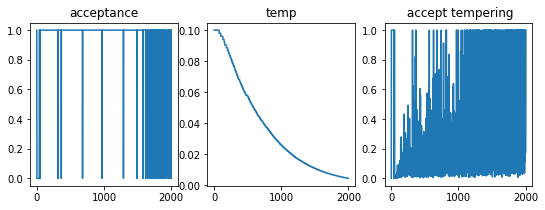

In [15]:
figure(figsize=(9,3))
subplot(131)
plot(trace[0]);
title('acceptance')
subplot(132)
plot(trace[1]);
title('temp')
subplot(133)
plot(clip(exp(trace[2]),0,1));
title(' accept tempering')

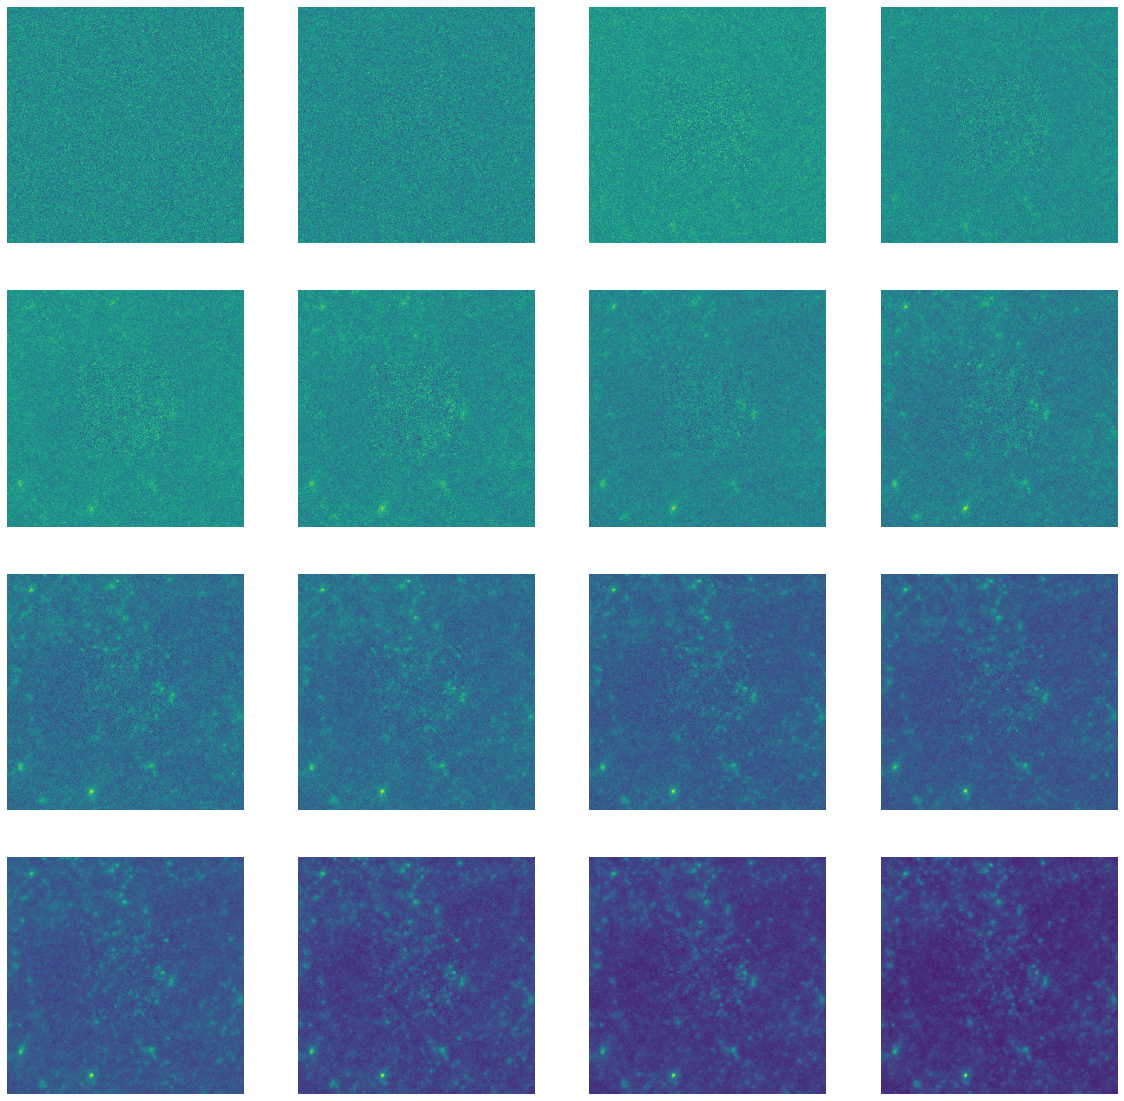

In [16]:
figure(figsize=(20,20))
for i in range(4):
  for j in range(4):
    subplot(4,4,4*i+j+1)
    imshow(samples[(4*i+j)*100,0].reshape((320,320)))
    axis('off')

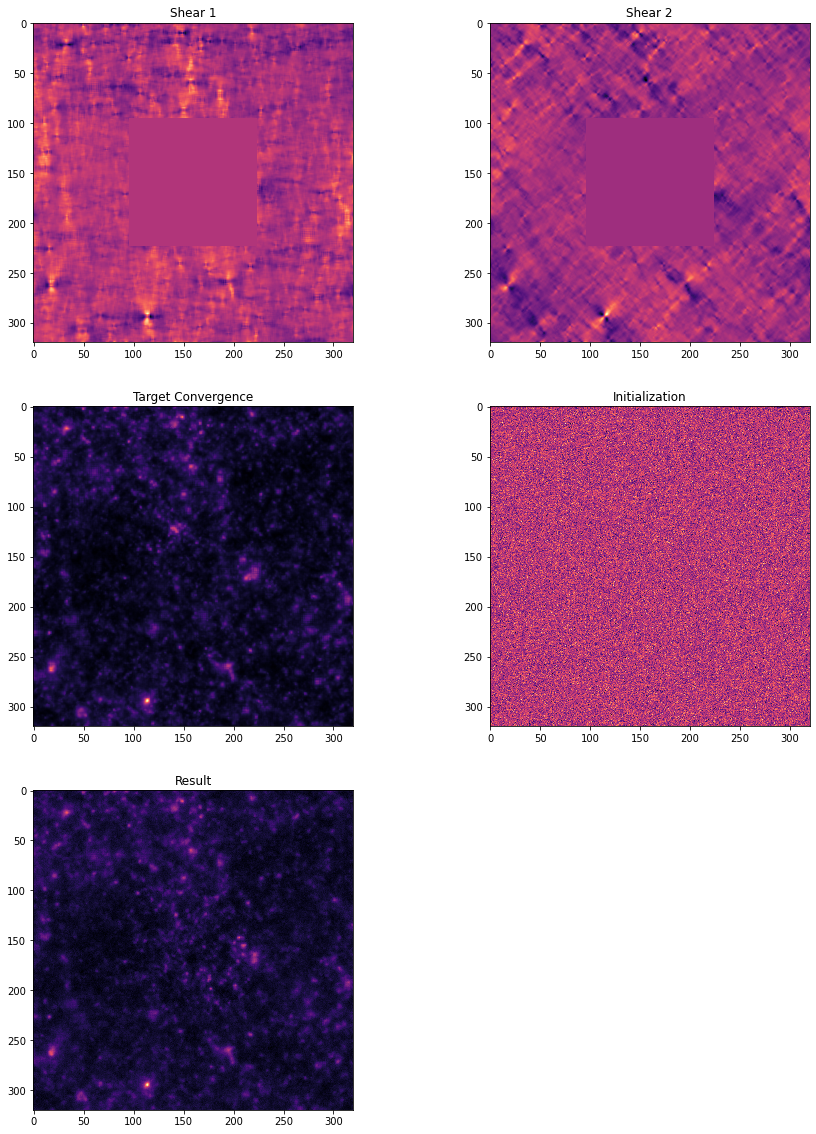

In [17]:
figure(figsize=(15,20))

plt.subplot(321)
imshow(masked_g1,cmap='magma') 
plt.title('Shear 1')

plt.subplot(322)
imshow(masked_g2,cmap='magma') 
plt.title('Shear 2')

plt.subplot(323)
imshow(e_mode,cmap='magma')
plt.title('Target Convergence')

plt.subplot(324)
imshow(init_image.reshape((320,320)), cmap='magma')
plt.title('Initialization')

plt.subplot(325)
imshow(samples[-1, 0].reshape((320, 320)),cmap='magma')
plt.title('Result')

plt.savefig('jax-lensing.png')